# Image Dehazing using SOTS

http://kaggle.com/code/meet2304/image-dehazing-sots-2 

In [1]:
# Import necessary libraries
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [2]:
# 1. Enhanced Dataset Class for Combined Indoor/Outdoor
# 1. Revised Dataset Class with Absolute Paths and Validation
class CombinedSOTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = os.path.abspath(root_dir)  # Use absolute path
        self.transform = transform
        self.pairs = []
        
        # Validate directory structure
        required_dirs = [
            os.path.join('indoor', 'hazy'),
            os.path.join('indoor', 'clear'),
            os.path.join('outdoor', 'hazy'),
            os.path.join('outdoor', 'clear')
        ]
        for rel_dir in required_dirs:
            abs_dir = os.path.join(self.root_dir, rel_dir)
            if not os.path.exists(abs_dir):
                raise FileNotFoundError(f"Required directory not found: {abs_dir}")
        
        # Find all valid pairs
        for subset in ['indoor', 'outdoor']:
            hazy_path = os.path.join(self.root_dir, subset, 'hazy')
            clear_path = os.path.join(self.root_dir, subset, 'clear')
            
            # Get sorted lists with case-insensitive search
            hazy_images = sorted([f for f in os.listdir(hazy_path) 
                                if f.lower().endswith('.png')])
            clear_images = sorted([f for f in os.listdir(clear_path) 
                                 if f.lower().endswith('.png')])
            
            # Create mapping from base number to clear files
            clear_map = {}
            for clear_file in clear_images:
                base = os.path.splitext(clear_file)[0]
                clear_map[base] = clear_file
                
            # Find matching hazy files
            for hazy_file in hazy_images:
                match = re.match(r"(\d+)[._]", hazy_file)
                if match:
                    base = match.group(1)
                    if base in clear_map:
                        full_hazy = os.path.join(subset, 'hazy', hazy_file)
                        full_clear = os.path.join(subset, 'clear', clear_map[base])
                        self.pairs.append((full_hazy, full_clear))

        if not self.pairs:
            raise RuntimeError("No valid hazy-clear pairs found!")
        print(f"Loaded {len(self.pairs)} valid image pairs")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        hazy_rel, clear_rel = self.pairs[idx]
        
        hazy_path = os.path.join(self.root_dir, hazy_rel)
        clear_path = os.path.join(self.root_dir, clear_rel)
        
        # Verify paths before loading
        if not os.path.exists(hazy_path):
            raise FileNotFoundError(f"Hazy image not found: {hazy_path}")
        if not os.path.exists(clear_path):
            raise FileNotFoundError(f"Clear image not found: {clear_path}")
            
        hazy_image = Image.open(hazy_path).convert('RGB')
        clear_image = Image.open(clear_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            clear_image = self.transform(clear_image)

        return hazy_image, clear_image

In [3]:
class LightDehaze_Net(nn.Module):
    def __init__(self):
        super(LightDehaze_Net, self).__init__()
        
        # LightDehazeNet Architecture
        self.relu = nn.ReLU(inplace=True)
        
        self.e_conv_layer1 = nn.Conv2d(3, 8, 1, 1, 0, bias=True)
        self.e_conv_layer2 = nn.Conv2d(8, 8, 3, 1, 1, bias=True)
        self.e_conv_layer3 = nn.Conv2d(8, 8, 5, 1, 2, bias=True)
        self.e_conv_layer4 = nn.Conv2d(16, 16, 7, 1, 3, bias=True)
        self.e_conv_layer5 = nn.Conv2d(16, 16, 3, 1, 1, bias=True)
        self.e_conv_layer6 = nn.Conv2d(16, 16, 3, 1, 1, bias=True)
        self.e_conv_layer7 = nn.Conv2d(32, 32, 3, 1, 1, bias=True)
        self.e_conv_layer8 = nn.Conv2d(56, 3, 3, 1, 1, bias=True)

    def forward(self, img):
        # Forward pass implementation
        conv_layer1 = self.relu(self.e_conv_layer1(img))
        conv_layer2 = self.relu(self.e_conv_layer2(conv_layer1))
        conv_layer3 = self.relu(self.e_conv_layer3(conv_layer2))
        
        # First concatenation
        concat_layer1 = torch.cat((conv_layer1, conv_layer3), 1)
        
        conv_layer4 = self.relu(self.e_conv_layer4(concat_layer1))
        conv_layer5 = self.relu(self.e_conv_layer5(conv_layer4))
        conv_layer6 = self.relu(self.e_conv_layer6(conv_layer5))
        
        # Second concatenation
        concat_layer2 = torch.cat((conv_layer4, conv_layer6), 1)
        
        conv_layer7 = self.relu(self.e_conv_layer7(concat_layer2))
        
        # Third concatenation
        concat_layer3 = torch.cat((conv_layer2, conv_layer5, conv_layer7), 1)
        
        conv_layer8 = self.relu(self.e_conv_layer8(concat_layer3))
        
        # Final dehazing equation
        dehaze_image = self.relu((conv_layer8 * img) - conv_layer8 + 1)
        
        return dehaze_image

In [4]:
# 3. Training Function with MAE Tracking
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    history = {'loss': [], 'mae': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_mae = 0.0
        
        for i, (hazy_images, clear_images) in enumerate(train_loader):
            hazy_images = hazy_images.to(device)
            clear_images = clear_images.to(device)
            
            optimizer.zero_grad()
            outputs = model(hazy_images)
            loss = criterion(outputs, clear_images)
            loss.backward()
            optimizer.step()
            
            # Calculate MAE
            mae = torch.mean(torch.abs(outputs - clear_images)).item()
            
            epoch_loss += loss.item()
            epoch_mae += mae
            
            if (i+1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, MAE: {mae:.4f}')
        
        # Store epoch averages
        avg_loss = epoch_loss / len(train_loader)
        avg_mae = epoch_mae / len(train_loader)
        history['loss'].append(avg_loss)
        history['mae'].append(avg_mae)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] completed. '
              f'Avg Loss: {avg_loss:.4f}, Avg MAE: {avg_mae:.4f}')
    
    return model, history

In [5]:
# 4. Enhanced Evaluation Function with MAE
def evaluate_model(model, test_loader, device):
    model.eval()
    psnr_values = []
    ssim_values = []
    mae_values = []
    
    with torch.no_grad():
        for hazy_images, clear_images in test_loader:
            hazy_images = hazy_images.to(device)
            clear_images = clear_images.to(device)
            outputs = model(hazy_images)
            
            # Convert to numpy for metrics
            outputs_np = outputs.cpu().numpy().transpose(0, 2, 3, 1)
            clear_np = clear_images.cpu().numpy().transpose(0, 2, 3, 1)
            
            for i in range(outputs_np.shape[0]):
                # Calculate metrics
                psnr_val = psnr(clear_np[i], outputs_np[i], data_range=1.0)
                ssim_val = ssim(clear_np[i], outputs_np[i], 
                              data_range=1.0, multichannel=True)
                mae_val = np.mean(np.abs(clear_np[i] - outputs_np[i]))
                
                psnr_values.append(psnr_val)
                ssim_values.append(ssim_val)
                mae_values.append(mae_val)
    
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    avg_mae = np.mean(mae_values)
    
    print(f'\nEvaluation Results:')
    print(f'PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f} | MAE: {avg_mae:.4f}')
    return avg_psnr, avg_ssim, avg_mae

In [6]:
def apply_histogram_equalization(image):
    # Convert tensor to numpy array for OpenCV operations
    if isinstance(image, torch.Tensor):
        if image.dim() == 4:  # Batch of images
            image = image[0]  # Take the first image in the batch
        image_np = image.permute(1, 2, 0).cpu().numpy()  # Change from CxHxW to HxWxC
        image_np = np.clip(image_np, 0, 1) * 255  # Scale from [0,1] to [0,255]
        image_np = image_np.astype(np.uint8)
    else:
        image_np = np.array(image)
    
    # Convert to YUV color space
    img_yuv = cv2.cvtColor(image_np, cv2.COLOR_RGB2YUV)
    
    # Apply histogram equalization to Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    
    # Convert back to RGB
    img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    return img_eq

def compare_images_with_histograms(hazy_image, dehazed_image, clear_image=None):
    # Apply histogram equalization
    hazy_eq = apply_histogram_equalization(hazy_image)
    dehazed_eq = apply_histogram_equalization(dehazed_image)
    
    # Create subplots
    fig, axes = plt.subplots(3, 3 if clear_image is not None else 2, figsize=(15, 15))
    
    # Convert tensor to numpy for displaying if needed
    if isinstance(hazy_image, torch.Tensor):
        hazy_display = hazy_image.permute(1, 2, 0).cpu().numpy()
    else:
        hazy_display = hazy_image
        
    if isinstance(dehazed_image, torch.Tensor):
        dehazed_display = dehazed_image.permute(1, 2, 0).cpu().numpy()
    else:
        dehazed_display = dehazed_image
    
    # Display original images
    axes[0, 0].imshow(hazy_display)
    axes[0, 0].set_title('Hazy Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(dehazed_display)
    axes[0, 1].set_title('Dehazed Image')
    axes[0, 1].axis('off')
    
    if clear_image is not None:
        if isinstance(clear_image, torch.Tensor):
            clear_display = clear_image.permute(1, 2, 0).cpu().numpy()
        else:
            clear_display = clear_image
            
        axes[0, 2].imshow(clear_display)
        axes[0, 2].set_title('Ground Truth Clear Image')
        axes[0, 2].axis('off')
    
    # Display histogram equalized images
    axes[1, 0].imshow(hazy_eq)
    axes[1, 0].set_title('Histogram Equalized Hazy Image')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(dehazed_eq)
    axes[1, 1].set_title('Histogram Equalized Dehazed Image')
    axes[1, 1].axis('off')
    
    if clear_image is not None:
        clear_eq = apply_histogram_equalization(clear_image)
        axes[1, 2].imshow(clear_eq)
        axes[1, 2].set_title('Histogram Equalized Ground Truth')
        axes[1, 2].axis('off')
    
    # Display histograms for RGB channels
    color = ('b', 'g', 'r')
    
    for i, col in enumerate(color):
        histr_hazy = cv2.calcHist([np.array(hazy_eq)], [i], None, [256], [0, 256])
        histr_dehazed = cv2.calcHist([np.array(dehazed_eq)], [i], None, [256], [0, 256])
        
        axes[2, 0].plot(histr_hazy, color=col)
        axes[2, 0].set_title('Histogram of Equalized Hazy Image')
        axes[2, 0].set_xlabel('Pixel Value')
        axes[2, 0].set_ylabel('Frequency')
        axes[2, 0].grid(True)
        
        axes[2, 1].plot(histr_dehazed, color=col)
        axes[2, 1].set_title('Histogram of Equalized Dehazed Image')
        axes[2, 1].set_xlabel('Pixel Value')
        axes[2, 1].set_ylabel('Frequency')
        axes[2, 1].grid(True)
        
        if clear_image is not None:
            histr_clear = cv2.calcHist([np.array(clear_eq)], [i], None, [256], [0, 256])
            axes[2, 2].plot(histr_clear, color=col)
            axes[2, 2].set_title('Histogram of Equalized Ground Truth')
            axes[2, 2].set_xlabel('Pixel Value')
            axes[2, 2].set_ylabel('Frequency')
            axes[2, 2].grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# 5. Main Execution Function
def main():
    # Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    root_dir = os.path.abspath('./datasets/sots')  # Adjust to your dataset path
    batch_size = 16
    num_epochs = 20
    save_path = './saved_models/cnn_lightdehaze_sots_pytorch/light_dehaze_combined_model.pth'

    # Verify root directory exists
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"Dataset directory not found: {root_dir}")
    print(f"Using dataset at: {root_dir}")

    # Create transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Initialize dataset with error handling
    try:
        print("\nLoading combined indoor/outdoor dataset...")
        full_dataset = CombinedSOTSDataset(root_dir=root_dir, transform=transform)
        print(f"Successfully loaded {len(full_dataset)} image pairs")
    except Exception as e:
        print(f"\nError loading dataset: {str(e)}")
        print("Please verify:")
        print("1. Dataset directory structure")
        print("2. File naming conventions")
        print("3. File extensions (.png)")
        return

    # Split dataset
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    print(f"\nDataset split:")
    print(f"- Training samples: {len(train_dataset)}")
    print(f"- Test samples: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # Initialize model
    model = LightDehaze_Net().to(device)
    criterion = nn.L1Loss()  # Using L1 loss for better MAE optimization
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=3
    )

    # Training loop
    print("\nStarting training...")
    best_mae = float('inf')
    train_history = {'loss': [], 'mae': []}

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_mae = 0.0
        
        for batch_idx, (hazy, clear) in enumerate(train_loader):
            hazy = hazy.to(device, non_blocking=True)
            clear = clear.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(hazy)
            
            loss = criterion(outputs, clear)
            loss.backward()
            optimizer.step()
            
            # Calculate batch metrics
            with torch.no_grad():
                mae = torch.mean(torch.abs(outputs - clear)).item()
            
            epoch_loss += loss.item()
            epoch_mae += mae
            
            # Print progress every 50 batches
            #if (batch_idx + 1) % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{len(train_loader)}] | "
                    f"Loss: {loss.item():.4f} | MAE: {mae:.4f} | LR: {current_lr:.2e}")

        # Epoch statistics
        avg_loss = epoch_loss / len(train_loader)
        avg_mae = epoch_mae / len(train_loader)
        train_history['loss'].append(avg_loss)
        train_history['mae'].append(avg_mae)
        scheduler.step(avg_loss)  # Update learning rate
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
        print(f"- Avg Loss: {avg_loss:.4f}")
        print(f"- Avg MAE: {avg_mae:.4f}")

        # Save best model
        if avg_mae < best_mae:
            best_mae = avg_mae
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model with MAE: {best_mae:.4f}")

    # Final evaluation
    print("\nTraining complete. Evaluating best model...")
    model.load_state_dict(torch.load(save_path))
    model.eval()
    
    psnr_values = []
    ssim_values = []
    mae_values = []
    
    with torch.no_grad():
        for hazy, clear in test_loader:
            hazy = hazy.to(device)
            clear = clear.to(device)
            outputs = model(hazy)
            
            # Convert to numpy for metrics
            outputs_np = outputs.cpu().numpy().transpose(0, 2, 3, 1)
            clear_np = clear.cpu().numpy().transpose(0, 2, 3, 1)
            
            for i in range(outputs_np.shape[0]):
                #psnr_val = psnr(clear_np[i], outputs_np[i], data_range=1.0)
                #ssim_val = ssim(clear_np[i], outputs_np[i], 
                #              data_range=1.0, channel_axis=-1)
                mae_val = np.mean(np.abs(clear_np[i] - outputs_np[i]))
                
                #psnr_values.append(psnr_val)
                #ssim_values.append(ssim_val)
                mae_values.append(mae_val)

    # Calculate final metrics
    final_psnr = np.mean(psnr_values)
    final_ssim = np.mean(ssim_values)
    final_mae = np.mean(mae_values)
    
    print("\nFinal Evaluation Results:")
    print(f"- PSNR: {final_psnr:.2f} dB")
    print(f"- SSIM: {final_ssim:.4f}")
    print(f"- MAE: {final_mae:.4f}")

    # Visualization
    print("\nVisualizing sample results...")
    sample_count = 0
    with torch.no_grad():
        for hazy, clear in test_loader:
            if sample_count >= 3:
                break
            hazy = hazy.to(device)
            clear = clear.to(device)
            outputs = model(hazy)
            
            for i in range(hazy.size(0)):
                compare_images_with_histograms(
                    hazy[i].cpu(),
                    outputs[i].cpu(),
                    clear[i].cpu()
                )
                sample_count += 1
                if sample_count >= 3:
                    break

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_history['mae'], label='Training MAE')
    plt.title('Training MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.tight_layout()
    plt.show()

Using dataset at: /Users/santoshs2/Documents/GitHub/computer-vision-python/datasets/sots

Loading combined indoor/outdoor dataset...
Loaded 500 valid image pairs
Successfully loaded 500 image pairs

Dataset split:
- Training samples: 400
- Test samples: 100

Starting training...


/opt/miniconda3/envs/cv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20] | Batch [1/25] | Loss: 0.5775 | MAE: 0.5775 | LR: 1.00e-03
Epoch [1/20] | Batch [2/25] | Loss: 0.6034 | MAE: 0.6034 | LR: 1.00e-03
Epoch [1/20] | Batch [3/25] | Loss: 0.5584 | MAE: 0.5584 | LR: 1.00e-03
Epoch [1/20] | Batch [4/25] | Loss: 0.5537 | MAE: 0.5537 | LR: 1.00e-03
Epoch [1/20] | Batch [5/25] | Loss: 0.5001 | MAE: 0.5001 | LR: 1.00e-03
Epoch [1/20] | Batch [6/25] | Loss: 0.4428 | MAE: 0.4428 | LR: 1.00e-03
Epoch [1/20] | Batch [7/25] | Loss: 0.3470 | MAE: 0.3470 | LR: 1.00e-03
Epoch [1/20] | Batch [8/25] | Loss: 0.2730 | MAE: 0.2730 | LR: 1.00e-03
Epoch [1/20] | Batch [9/25] | Loss: 0.2149 | MAE: 0.2149 | LR: 1.00e-03
Epoch [1/20] | Batch [10/25] | Loss: 0.1460 | MAE: 0.1460 | LR: 1.00e-03
Epoch [1/20] | Batch [11/25] | Loss: 0.1917 | MAE: 0.1917 | LR: 1.00e-03
Epoch [1/20] | Batch [12/25] | Loss: 0.2171 | MAE: 0.2171 | LR: 1.00e-03
Epoch [1/20] | Batch [13/25] | Loss: 0.2173 | MAE: 0.2173 | LR: 1.00e-03
Epoch [1/20] | Batch [14/25] | Loss: 0.2483 | MAE: 0.2483 | 

/opt/miniconda3/envs/cv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/cv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Final Evaluation Results:
- PSNR: nan dB
- SSIM: nan
- MAE: 0.0817

Visualizing sample results...


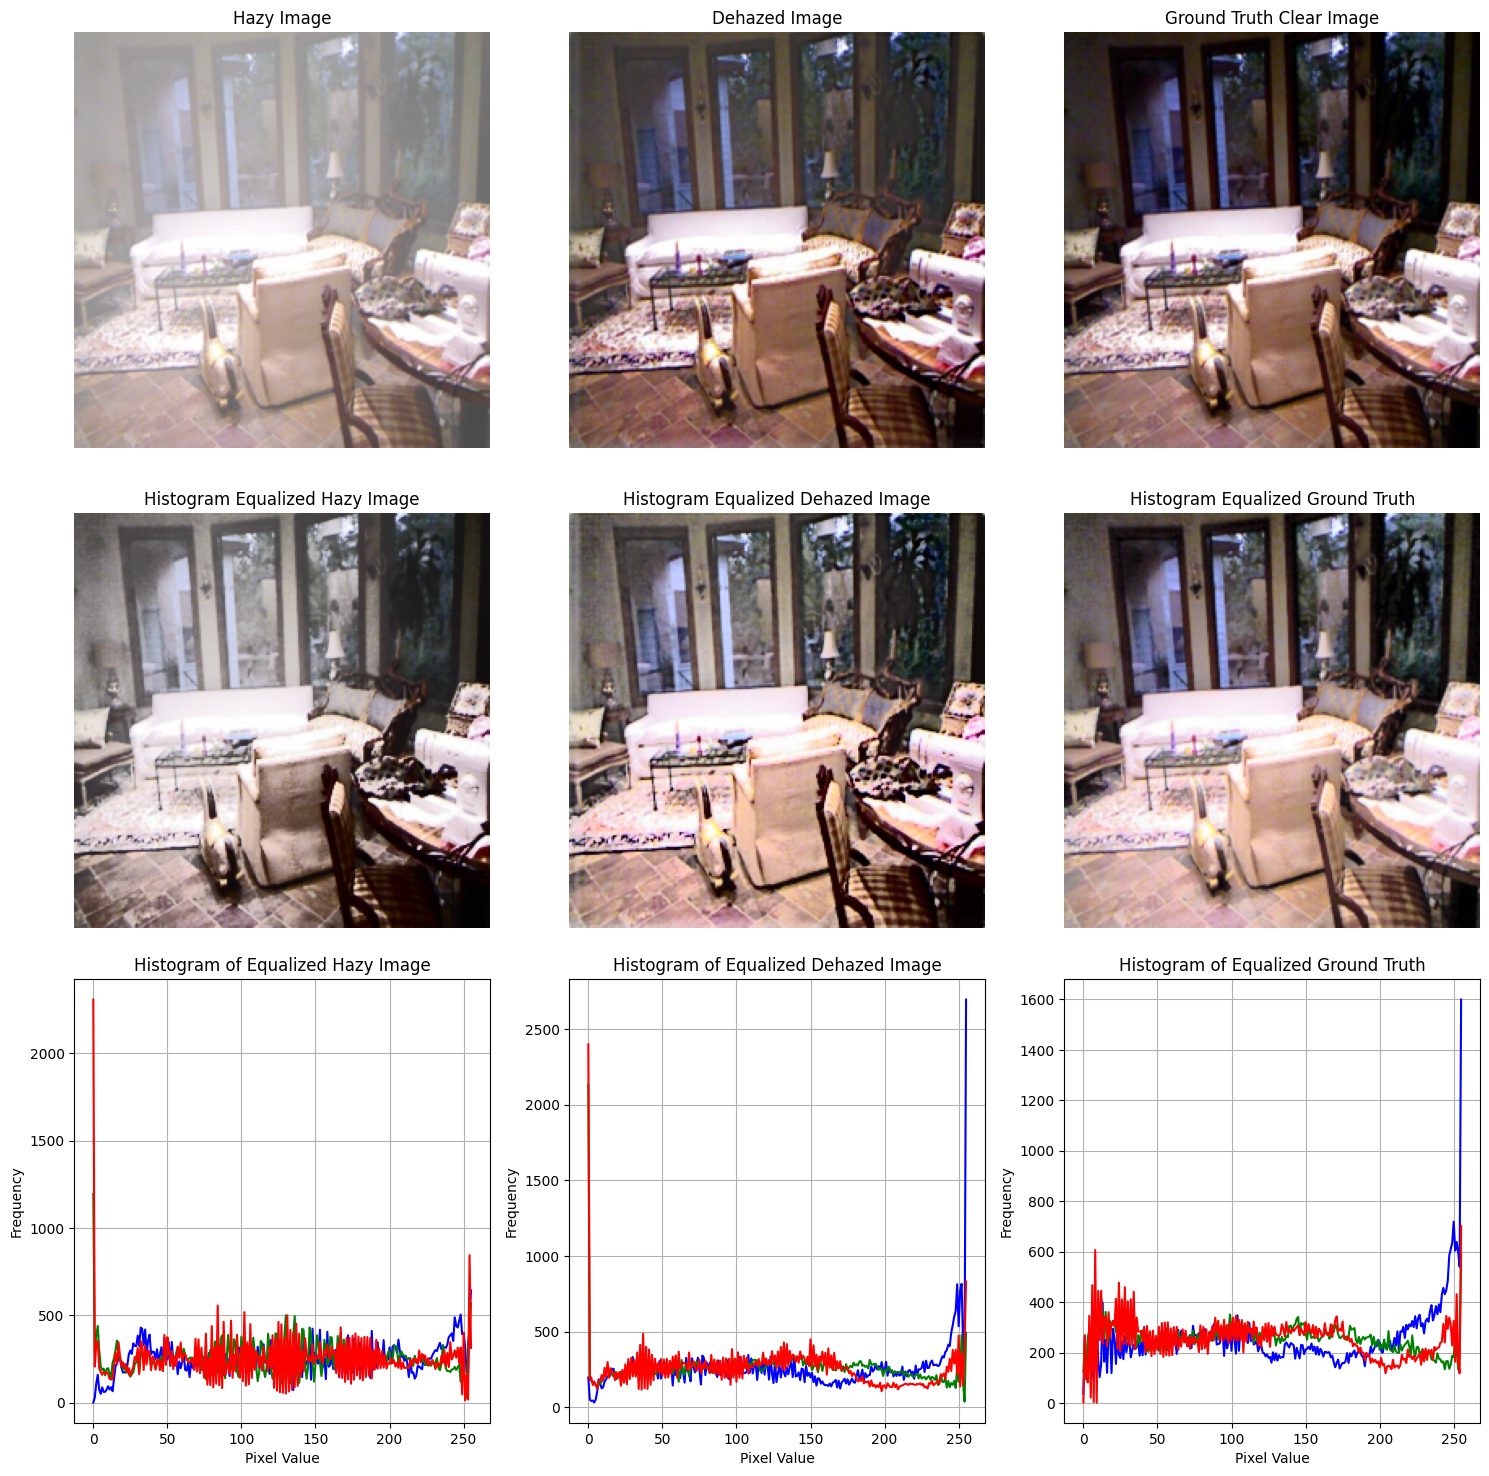

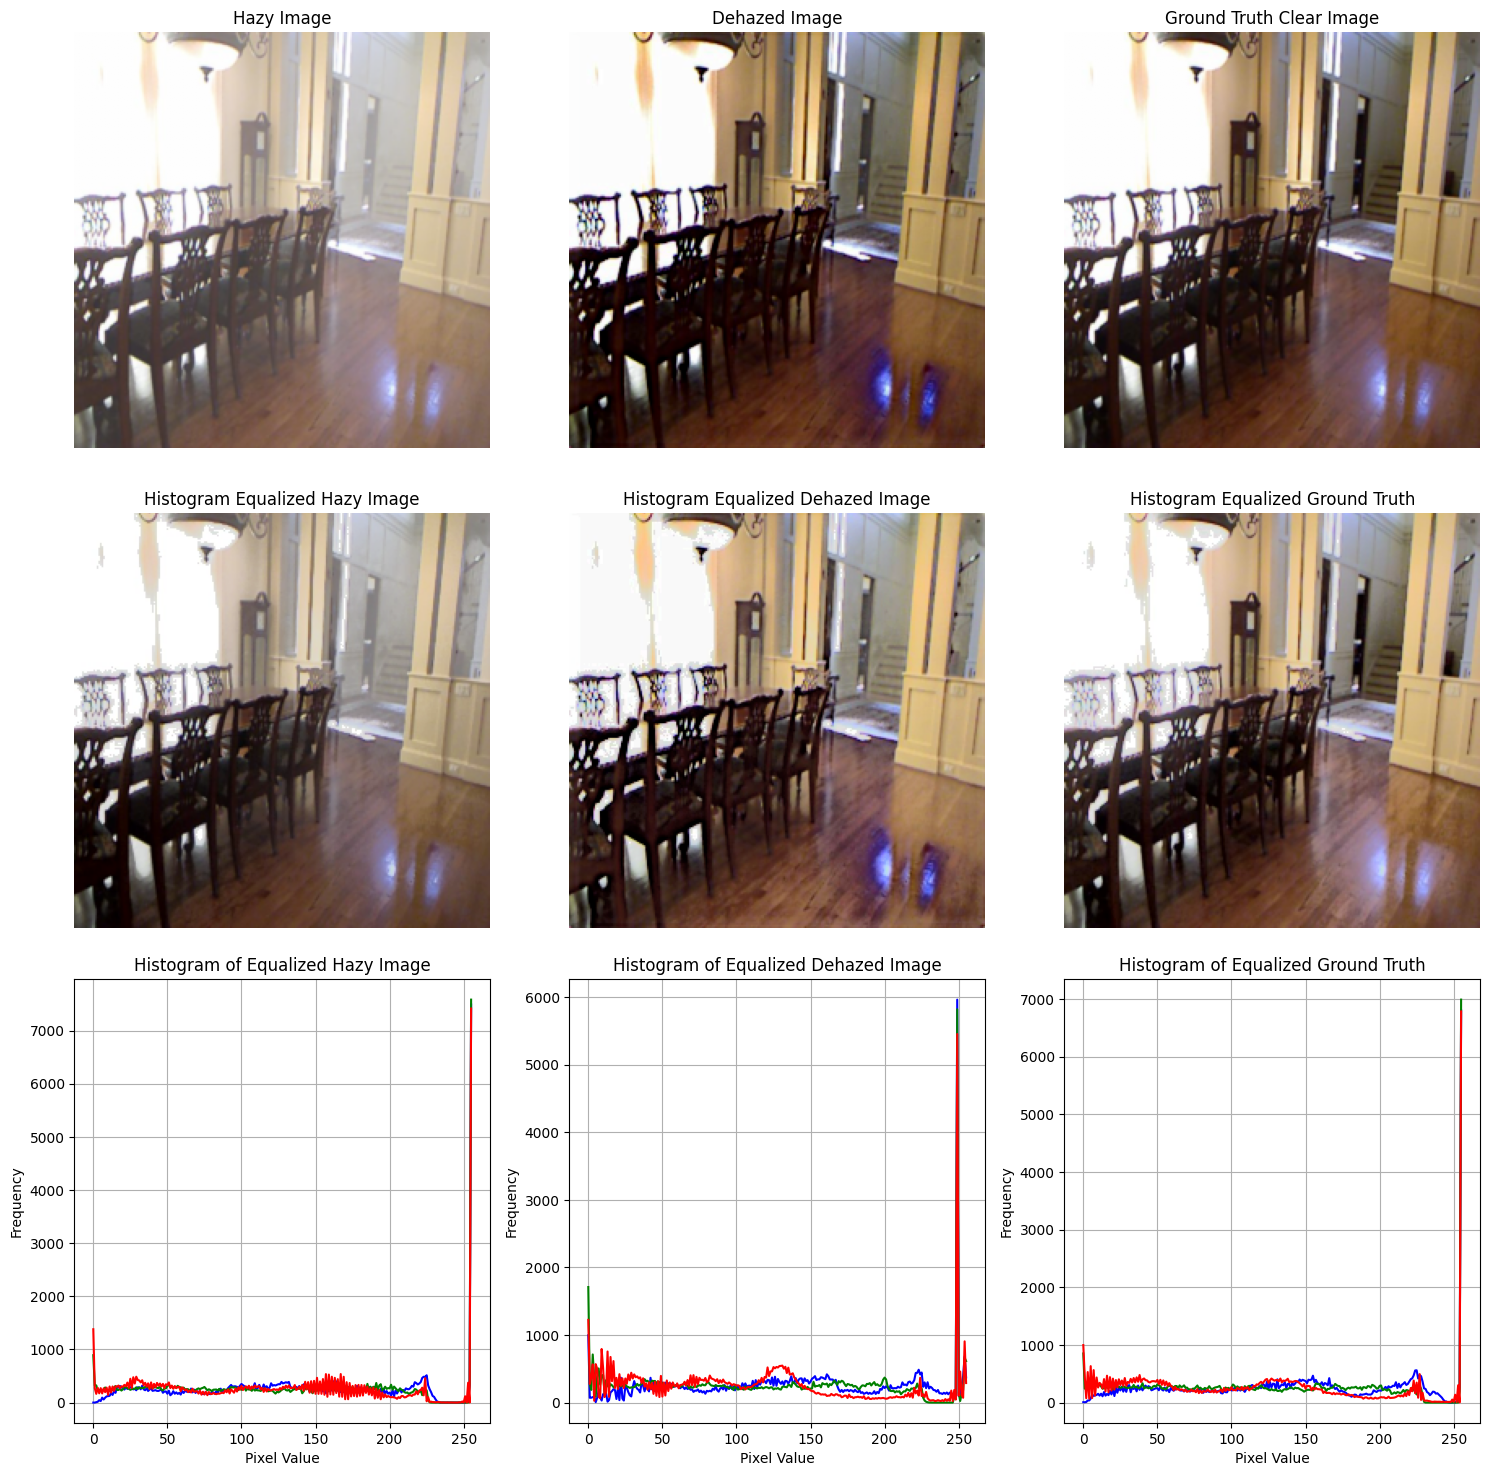

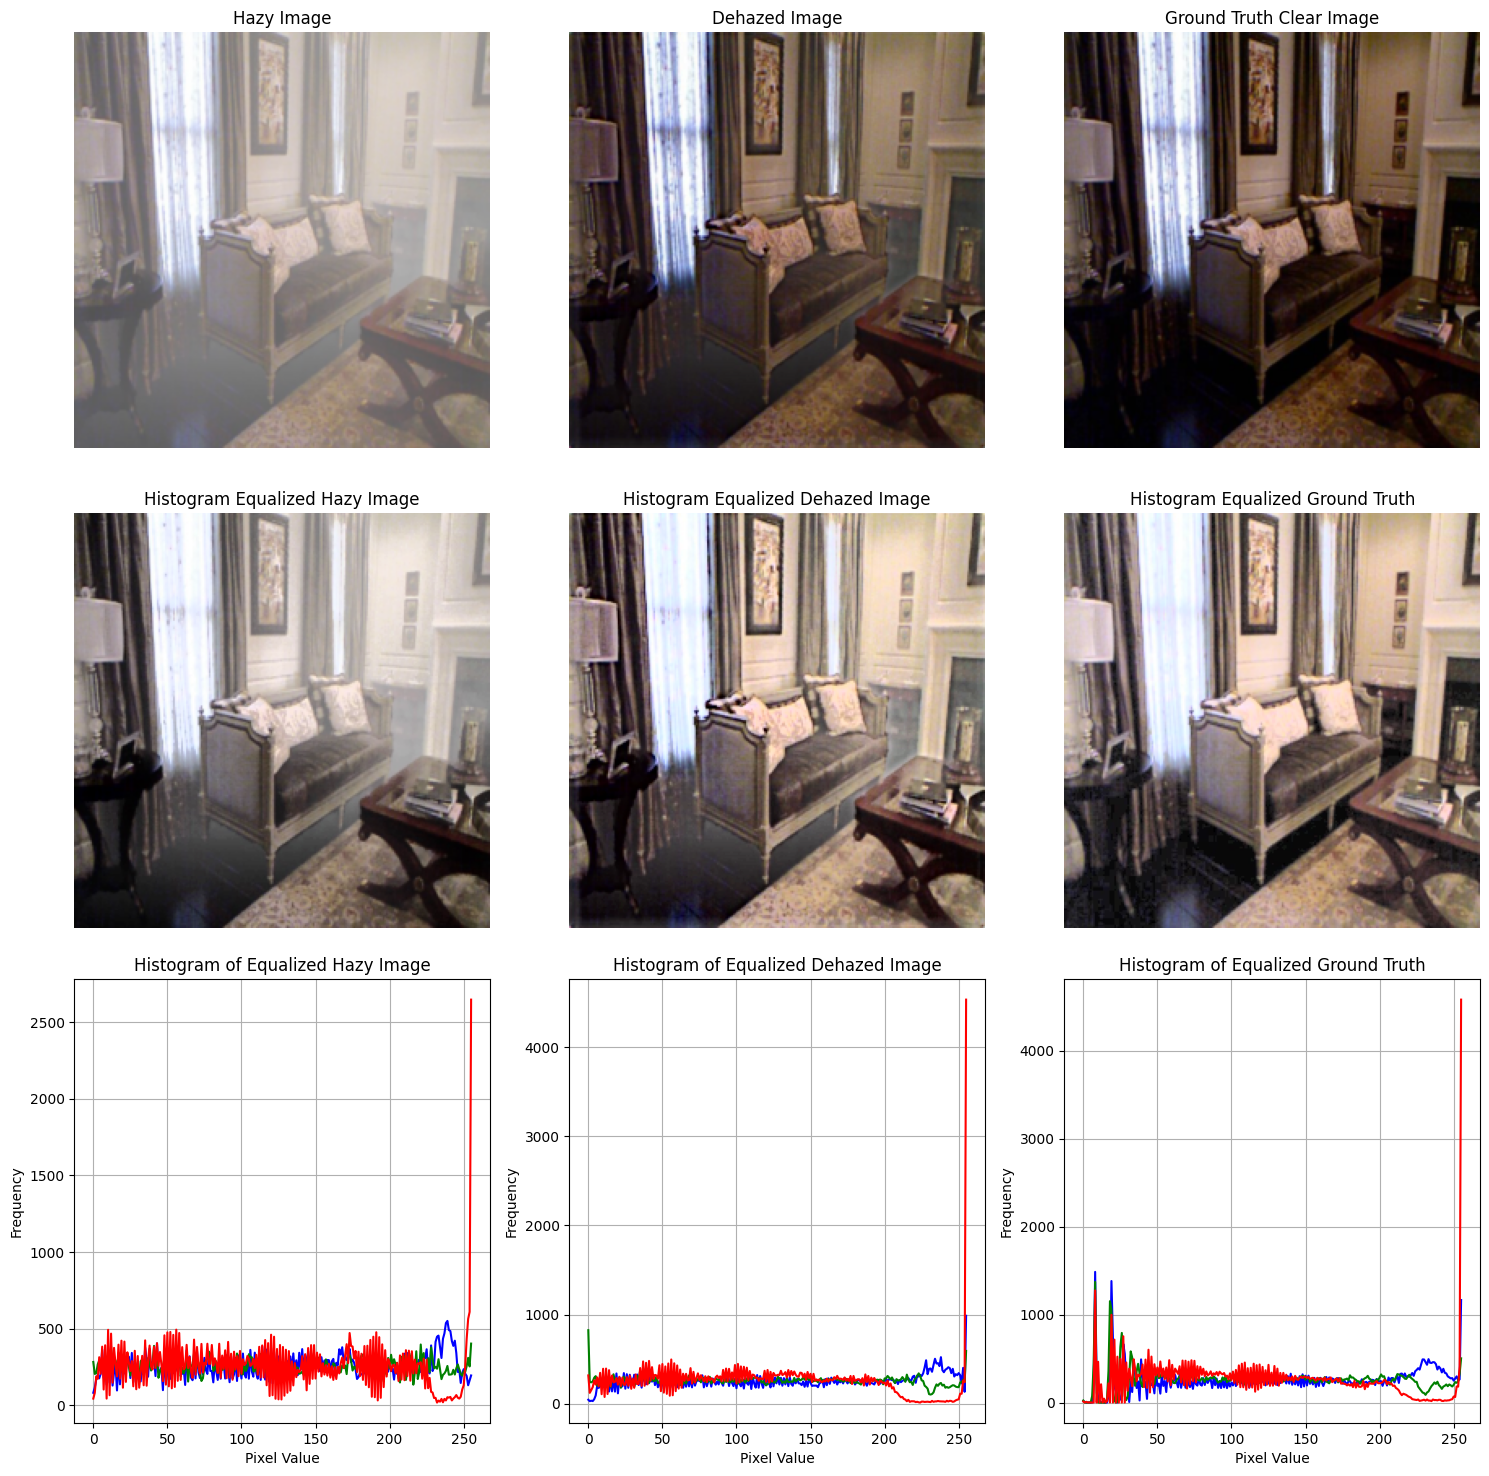

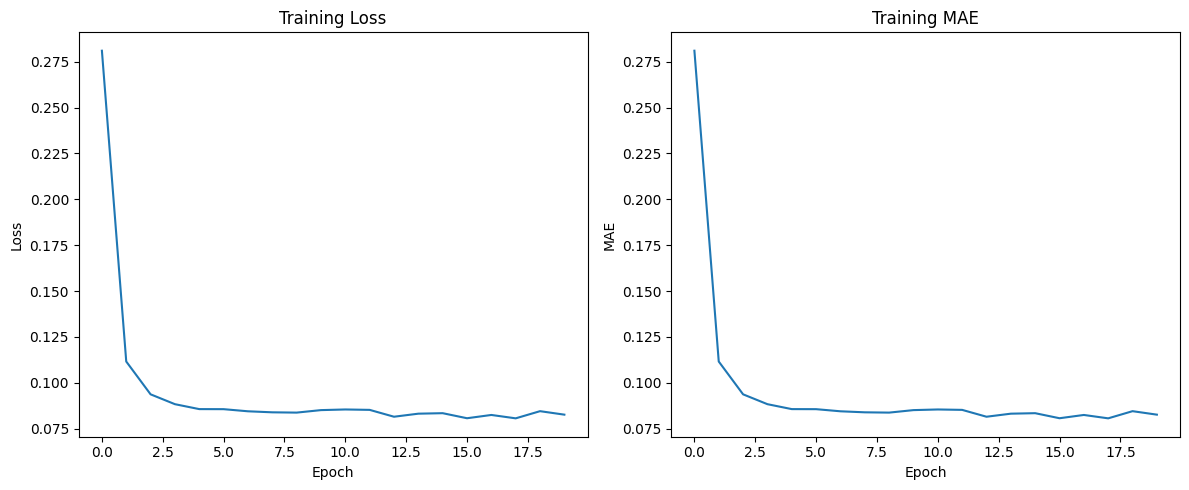

In [8]:
if __name__ == "__main__":
    main()